In [1]:
!pip install viser -q
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import viser, time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from IPython.display import HTML
from base64 import b64encode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Part 1: Fit a Neural Field to a 2D Image**

# **Implement Network**

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_frequencies=10):
        super(PositionalEncoding, self).__init__()
        self.freq_bands = torch.tensor([2 ** i for i in range(num_frequencies)])

    def forward(self, x):
        encodings = []

        for band in self.freq_bands:
            encodings.append(torch.sin(band * math.pi * x))
            encodings.append(torch.cos(band * math.pi * x))

        pe = torch.cat([x] + encodings, dim=-1)
        return pe

class MLPwithPE(nn.Module):
    def __init__(self, num_dims=2, num_frequencies=10):
        super(MLPwithPE, self).__init__()

        self.num_dims = num_dims
        self.num_frequencies = num_frequencies
        self.pe = PositionalEncoding(num_frequencies)

        self.mlp = nn.Sequential(
            nn.Linear(num_frequencies * 2 * num_dims + num_dims, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3), # 3 for RGB; if you want grayscale, make it 1
            nn.Sigmoid()
        )

    def forward(self, coords):
        positional_encodings = self.pe(coords)
        output = self.mlp(positional_encodings)
        return output

# **Read in Fox Image**

In [4]:
def show_image(im, points=None, with_points=False, with_axis=False, cmap=None, title=""):
    fig, ax = plt.subplots()

    if not with_axis: plt.axis('off')
    if with_points: ax.plot(points[:, 0], points[:, 1], 'bo', ms=3)
    if title: ax.set_title(title)

    if cmap:
        ax.imshow(im, cmap=cmap)
    else:
        ax.imshow(im)

    plt.show()

In [6]:
fox_img = cv2.imread('/fox.jpg')
fox_img = cv2.cvtColor(fox_img, cv2.COLOR_BGR2RGB)

# **Implement Dataloader**

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image, num_samples):
        super().__init__()

        self.image = torch.tensor(image, dtype=torch.float32) / 255.0
        self.height, self.width, _ = self.image.shape
        self.num_samples = num_samples

    def __len__(self):
        return 100

    def __getitem__(self, index):
        sampled_rows = np.random.randint(0, self.height, self.num_samples)
        sampled_cols = np.random.randint(0, self.width, self.num_samples)

        coords = np.stack((sampled_cols / self.width, sampled_rows / self.height), axis=-1)
        colors = self.image[sampled_rows, sampled_cols]

        return torch.tensor(coords, dtype=torch.float32), torch.tensor(colors, dtype=torch.float32)

def generate_coordinate_grid(img_shape):
    height, width, _ = img_shape
    grid_y, grid_x = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')

    coords = torch.stack([grid_x, grid_y], dim=-1).float()
    coords = coords / torch.tensor([width, height], dtype=torch.float32)
    return coords.view(-1,2)

def reconstruct_image(model, image_shape, device):
    coords = generate_coordinate_grid(image_shape).to(device)

    with torch.no_grad():
        predictions = model(coords)

    reconstructed_image = predictions.view(image_shape[0], image_shape[1], 3)
    return reconstructed_image.cpu().numpy()

# **Train Network**

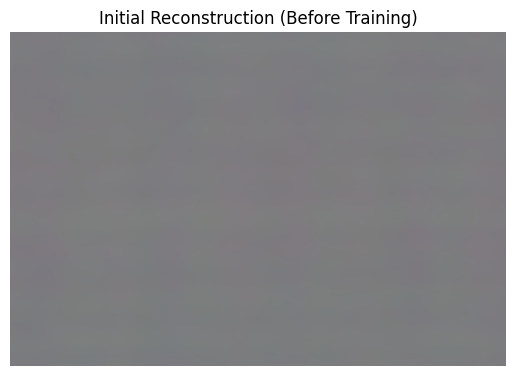

<ipython-input-7-54ed8ad12f5c>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(coords, dtype=torch.float32), torch.tensor(colors, dtype=torch.float32)


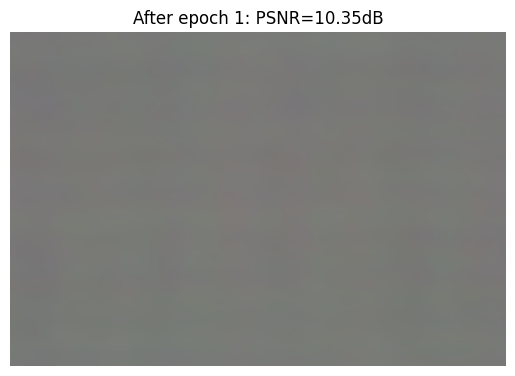

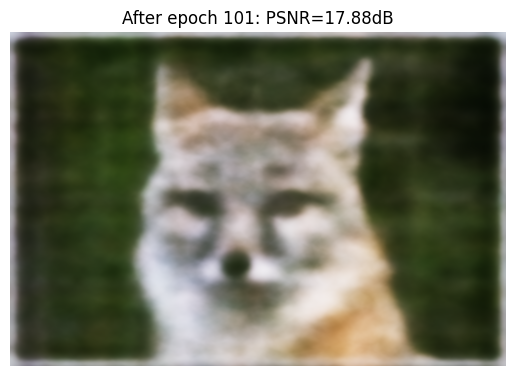

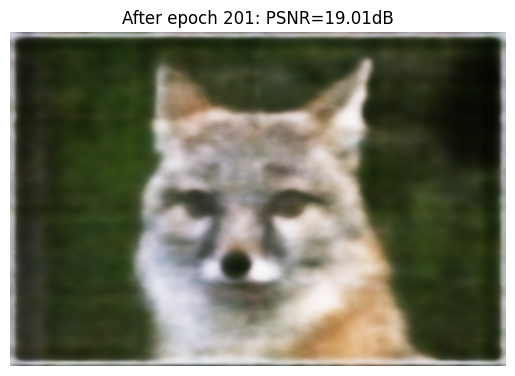

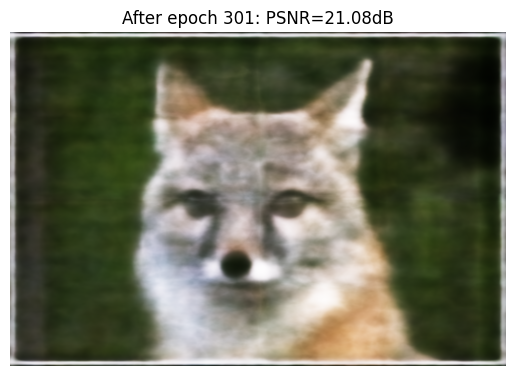

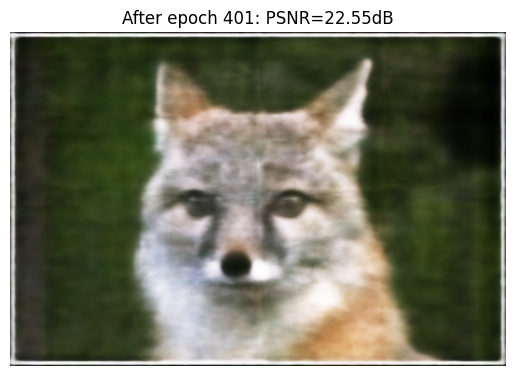

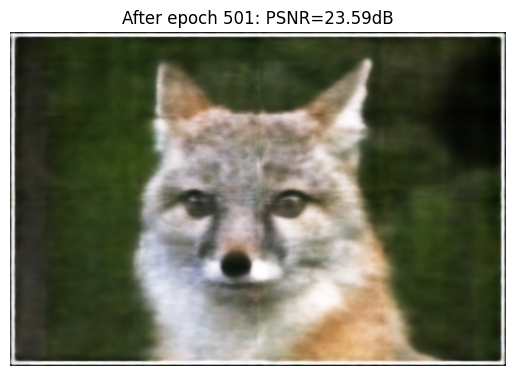

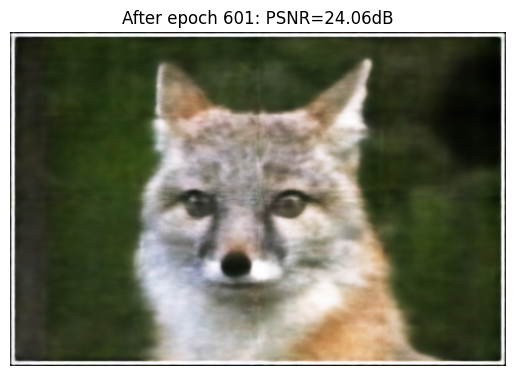

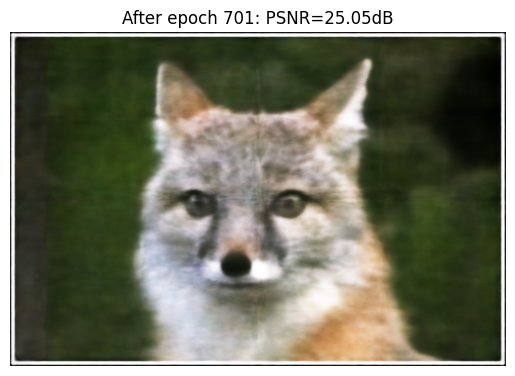

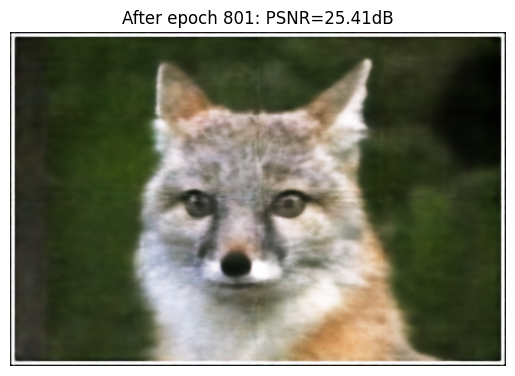

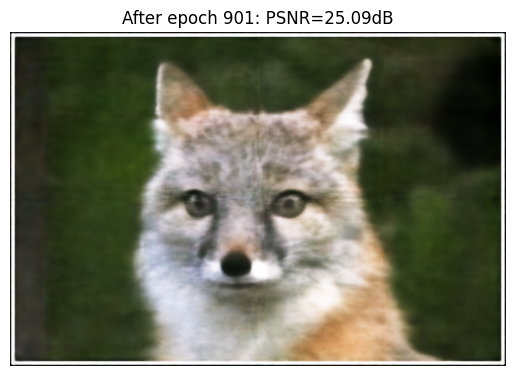

In [8]:
model = MLPwithPE(num_frequencies=5).to(device)

num_epochs, batch_size = 1000, 2500

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

dataset = ImageDataset(fox_img, batch_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

initial_noise = reconstruct_image(model, fox_img.shape, device)
show_image(initial_noise, title="Initial Reconstruction (Before Training)")

epoch_losses, psnrs = [], []

def compute_psnr(mse):
    return 10 * math.log10(1.0 / mse)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for coords, rgb_vals in dataloader:
        coords = coords.squeeze(0).to(device)
        rgb_vals = rgb_vals.squeeze(0).to(device)

        prediction = model(coords)
        loss = loss_fn(prediction, rgb_vals)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        psnrs.append(compute_psnr(loss.item()))

    epoch_loss /= len(dataloader)
    epoch_losses.append(epoch_loss)

    if epoch % 100 == 0:
        reconstructed_image = reconstruct_image(model, fox_img.shape, device)
        show_image(reconstructed_image, title=f"After epoch {epoch+1}: PSNR={psnrs[-1]:.2f}dB")

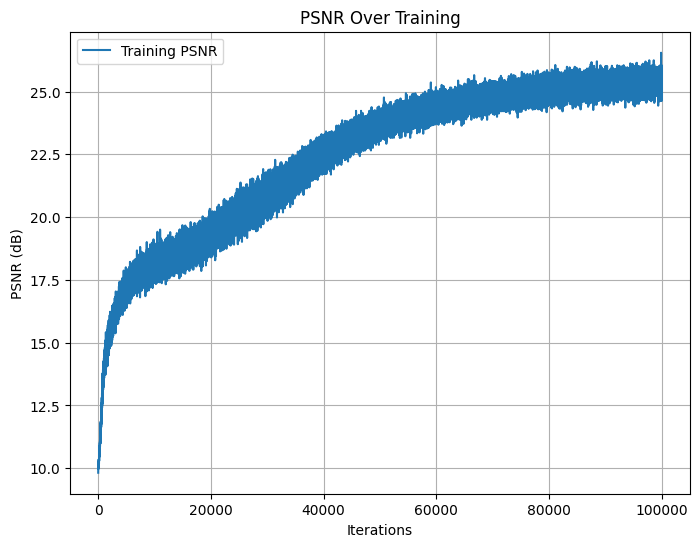

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(len(psnrs)), psnrs, label='Training PSNR')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Over Training')
plt.legend()
plt.grid(True)
plt.show()

# Repeat Reconstruction Process For Bird

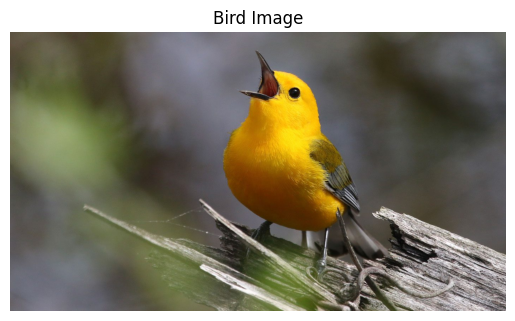

In [11]:
bird_img = cv2.imread('/bird.jpg')
bird_img = cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB)
show_image(bird_img, title="Bird Image")

<ipython-input-15-8aafa2722be7>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(coords, dtype=torch.float32), torch.tensor(colors, dtype=torch.float32)


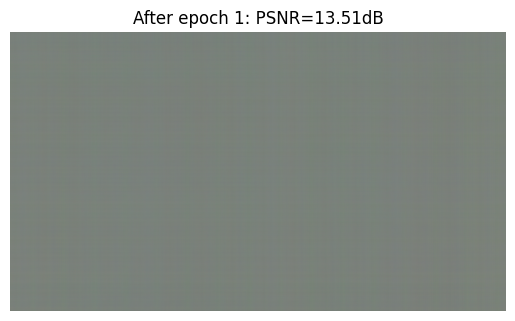

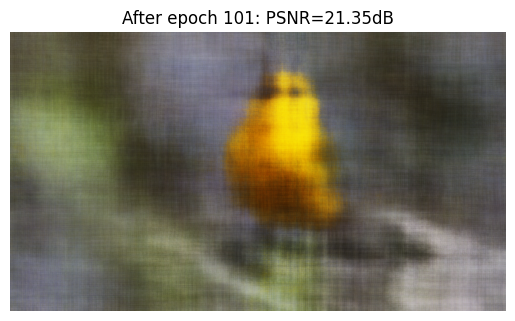

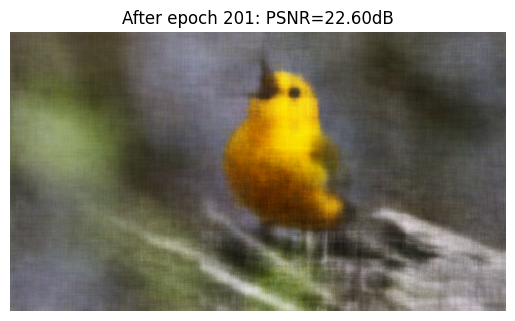

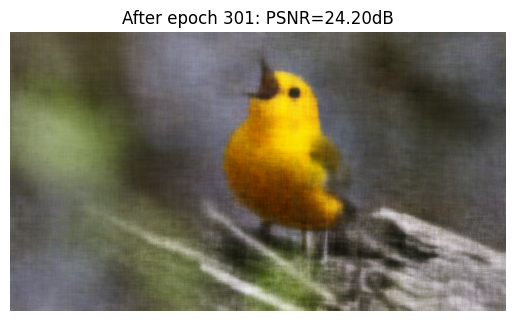

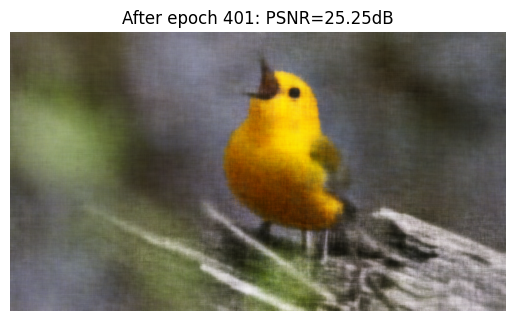

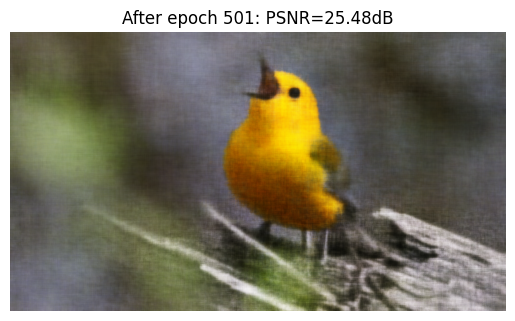

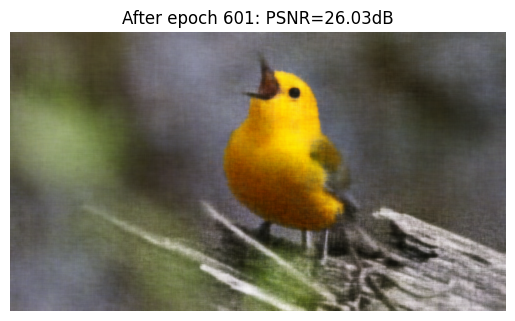

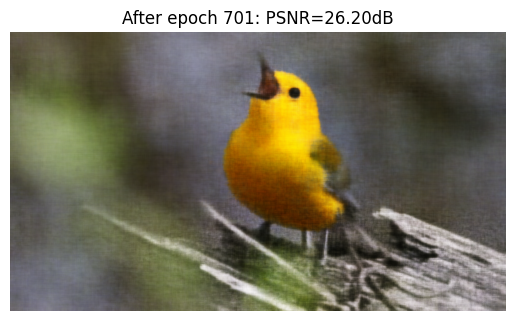

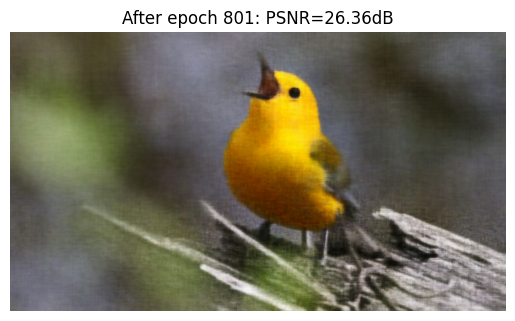

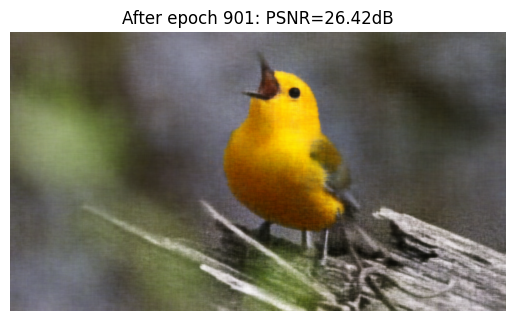

In [25]:
model = MLPwithPE().to(device)

num_epochs, batch_size = 1000, 2500

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

dataset = ImageDataset(bird_img, batch_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

epoch_losses, psnrs = [], []

def compute_psnr(mse):
    return 10 * math.log10(1.0 / mse)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for coords, rgb_vals in dataloader:
        coords = coords.squeeze(0).to(device)
        rgb_vals = rgb_vals.squeeze(0).to(device)

        prediction = model(coords)
        loss = loss_fn(prediction, rgb_vals)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        psnrs.append(compute_psnr(loss.item()))

    epoch_loss /= len(dataloader)
    epoch_losses.append(epoch_loss)

    if epoch % 100 == 0:
        reconstructed_image = reconstruct_image(model, bird_img.shape, device)
        show_image(reconstructed_image, title=f"After epoch {epoch+1}: PSNR={psnrs[-1]:.2f}dB")

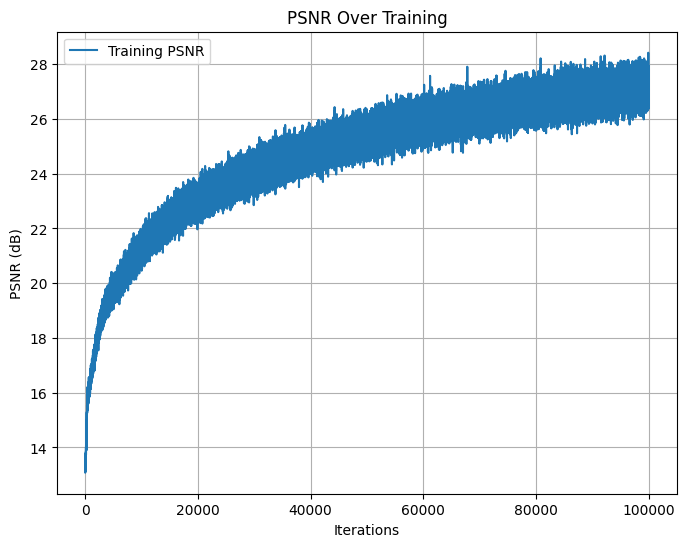

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(torch.arange(len(psnrs)), psnrs, label='Training PSNR')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Over Training')
plt.legend()
plt.grid(True)
plt.show()

# **Part 2: Fit a Neural Radiance Field from Multi-view Images**

In [13]:
data = np.load("/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = float(data["focal"])  # float

# **Part 2.1: Create Rays From Cameras**

In [15]:
def transform(c2w, x_c):
    device = x_c.device
    c2w = c2w.to(device).to(torch.float32)
    x_c = x_c.to(torch.float32)

    ones = torch.ones_like(x_c[..., :1], device=device, dtype=torch.float32)
    x_c_h = torch.cat([x_c, ones], dim=-1)

    x_w_h = torch.matmul(c2w, x_c_h.unsqueeze(-1)).squeeze(-1)
    x_w = x_w_h[..., :3] / x_w_h[..., 3:]
    return x_w

def pixel_to_camera(K, uv, s):
    f_x, f_y = K[0, 0], K[1, 1]
    o_x, o_y = K[0, 2], K[1, 2]
    u, v = uv[..., 0], uv[..., 1]
    x_c = ((u - o_x)/f_x) * s
    y_c = ((v - o_y)/f_y) * s
    z_c = torch.ones_like(u) * s
    return torch.stack([x_c, y_c, z_c], dim=-1)

def pixel_to_ray(K, c2w, uv):
    device = uv.device
    K = K.to(device).to(torch.float32)
    c2w = c2w.to(device).to(torch.float32)

    zeros_cam = torch.zeros((uv.shape[0], 3), device=device, dtype=torch.float32)
    rays_o = transform(c2w, zeros_cam)

    x_c = pixel_to_camera(K, uv, s=1.0).to(torch.float32)
    X_w = transform(c2w, x_c)

    direction = X_w - rays_o
    direction = direction / direction.norm(dim=-1, keepdim=True)
    return rays_o, direction

# **Part 2.2.1: Sampling Rays From Images**

In [16]:
def sample_random_rays(images_train, c2ws_train, K, N_rays):
    N_images, H, W, _ = images_train.shape
    device = images_train.device

    img_indices = torch.randint(0, N_images, (N_rays,), device=device)

    u, v = torch.randint(0, W, (N_rays,), device=device).float() + 0.5, torch.randint(0, H, (N_rays,), device=device).float() + 0.5

    c2ws_selected = c2ws_train[img_indices]

    uv = torch.stack([u, v], dim=-1)

    rays_o, rays_d = pixel_to_ray(K, c2ws_selected, uv)
    v_long, u_long = v.long(), u.long()
    colors = images_train[img_indices, v_long, u_long]  # [N_rays, 3]

    return rays_o, rays_d, colors

# **Part 2.2.2: Sampling Points Along Rays**

In [17]:
def sample_along_rays(rays_o, rays_d, near=2.0, far=6.0, N_samples=64, perturb=True):
    device = rays_o.device

    t_vals = torch.linspace(near, far, N_samples, device=device)
    t_vals = t_vals.unsqueeze(0).repeat(rays_o.shape[0], 1)  # [N_rays, N_samples]

    if perturb:
        mid = 0.5 * (t_vals[:, :-1] + t_vals[:, 1:])
        upper = torch.cat([mid, t_vals[:, -1:]], dim=-1)
        lower = torch.cat([t_vals[:, :1], mid], dim=-1)
        t_rand = torch.rand_like(t_vals)
        t_vals = lower + (upper - lower) * t_rand

    points = rays_o.unsqueeze(1) + rays_d.unsqueeze(1) * t_vals.unsqueeze(-1)

    return points, t_vals

# **Part 2.3: Putting the DataLoading All Together**

In [18]:
class RaysData:
    def __init__(self, images_train, K, c2ws_train):
        self.images_train = torch.tensor(images_train, dtype=torch.float32)
        self.K = torch.tensor(K, dtype=torch.float32)
        self.c2ws_train = torch.tensor(c2ws_train, dtype=torch.float32)
        self.N_images, self.H, self.W, _ = self.images_train.shape

    def sample_rays(self, B):
        img_indices = torch.randint(0, self.N_images, (B,))
        u = torch.randint(0, self.W, (B,)).float() + 0.5
        v = torch.randint(0, self.H, (B,)).float() + 0.5

        uv = torch.stack([u, v], dim=-1)
        c2ws = self.c2ws_train[img_indices]

        rays_o, rays_d = self.pixel_to_ray(self.K, c2ws, uv)
        pixels = self.images_train[img_indices, v.long(), u.long()]

        return rays_o, rays_d, pixels

    def pixel_to_camera(self, K, uv, s=1.0):
        f_x, f_y = K[0, 0], K[1, 1]
        o_x, o_y = K[0, 2], K[1, 2]
        u, v = uv[..., 0], uv[..., 1]
        x_c = ((u - o_x)/f_x) * s
        y_c = ((v - o_y)/f_y) * s
        z_c = torch.ones_like(u) * s
        return torch.stack([x_c, y_c, z_c], dim=-1)

    def transform(self, c2w, x_c):
        device = x_c.device
        c2w = c2w.to(device).to(torch.float32)
        x_c = x_c.to(torch.float32)

        ones = torch.ones_like(x_c[..., :1], device=device, dtype=torch.float32)
        x_c_h = torch.cat([x_c, ones], dim=-1)

        x_w_h = torch.matmul(c2w, x_c_h.unsqueeze(-1)).squeeze(-1)
        x_w = x_w_h[..., :3] / x_w_h[..., 3:]
        return x_w

    def pixel_to_ray(self, K, c2w, uv):
        device = uv.device
        K = K.to(device).to(torch.float32)
        c2w = c2w.to(device).to(torch.float32)

        zeros_cam = torch.zeros((uv.shape[0], 3), device=device, dtype=torch.float32)
        rays_o = self.transform(c2w, zeros_cam)

        x_c = self.pixel_to_camera(K, uv, s=1.0).to(torch.float32)
        X_w = self.transform(c2w, x_c)

        direction = X_w - rays_o
        direction = direction / direction.norm(dim=-1, keepdim=True)
        return rays_o, direction

In [19]:
H, W = images_train.shape[1:3]
H, W = int(H), int(W)

K = torch.tensor([[focal,    0.0,   W/2.0],
    [0.0,    focal,   H/2.0],
    [0.0,     0.0,    1.0]], dtype=torch.float32)

dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100)
points = sample_along_rays(rays_o, rays_d, perturb=True)[0]

rays_o_np = rays_o.numpy()
rays_d_np = rays_d.numpy()
points_np = points.numpy()

images_train_np = images_train
if torch.is_tensor(images_train_np):
    images_train_np = images_train_np

c2ws_train_np = c2ws_train
if torch.is_tensor(c2ws_train_np):
    c2ws_train_np = c2ws_train_np.numpy()

K_np = K.numpy()

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train_np, c2ws_train_np)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K_np[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o_np, rays_d_np)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points_np).reshape(-1, 3),
    points=points_np.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

<ipython-input-18-2ea2230d44a6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.K = torch.tensor(K, dtype=torch.float32)


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8081   │
│   Websocket │ ws://localhost:8081     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 32 clients): https://distorted-splats.share.viser.studio

<ipython-input-19-007f4f3ed536>:28: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
<ipython-input-19-007f4f3ed536>:38: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
<ipython-input-19-007f4f3ed536>:41: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Connection opened (0, 1 total), 608 persistent messages

(viser) Connection closed (0, 0 total)

(viser) Disconnected from share URL

KeyboardInterrupt: 

# **Part 2.4: Neural Radiance Field**

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_frequencies=10):
        super(PositionalEncoding, self).__init__()
        freq_bands = [2**i for i in range(num_frequencies)]
        self.register_buffer('freq_bands', torch.tensor(freq_bands, dtype=torch.float32))

    def forward(self, x):
        encodings = [x]
        for band in self.freq_bands:
            encodings.append(torch.sin(band * math.pi * x))
            encodings.append(torch.cos(band * math.pi * x))
        return torch.cat(encodings, dim=-1)

class NeuralRadianceField(nn.Module):
    def __init__(self, num_frequencies_xyz=10, num_frequencies_dir=4, D=8, W=256):
        super(NeuralRadianceField, self).__init__()

        self.pe_xyz = PositionalEncoding(num_frequencies_xyz)
        self.pe_dir = PositionalEncoding(num_frequencies_dir)
        self.xyz_dim = 3 * (2 * num_frequencies_xyz + 1)
        self.dir_dim = 3 * (2 * num_frequencies_dir + 1)
        self.layers_xyz = nn.ModuleList()
        self.layers_xyz.append(nn.Linear(self.xyz_dim, W))

        for i in range(1, D):
            if i == 4:
                self.layers_xyz.append(nn.Linear(W + self.xyz_dim, W))
            else:
                self.layers_xyz.append(nn.Linear(W, W))

        self.sigma_linear = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        self.color_layers = nn.Sequential(
            nn.Linear(W + self.dir_dim, W//2),
            nn.ReLU(),
            nn.Linear(W//2, 3),
            nn.Sigmoid()
        )

    def forward(self, x, d):
        x_enc, d_enc = self.pe_xyz(x), self.pe_dir(d)
        h = x_enc

        for i, layer in enumerate(self.layers_xyz):
            if i == 4:
                h = torch.cat([h, x_enc], dim=-1)

            h = layer(h)
            h = torch.relu(h)

        sigma = self.sigma_linear(h)
        sigma = torch.relu(sigma)

        feature = self.feature_linear(h)
        h_color = torch.cat([feature, d_enc], dim=-1)
        rgb = self.color_layers(h_color)

        return rgb, sigma

# **Part 2.5: Volume Rendering**

In [21]:
def volrend(sigmas, rgbs, step_size, background_color=(0.0, 0.0, 0.0)):
    # assert sigmas.shape[:-1] == rgbs.shape[:-1], "Sigmas and RGBs must match in dimensions"
    # assert sigmas.shape[-1] == 1, "Sigmas must have last dimension 1"
    # assert rgbs.shape[-1] == 3, "RGBs must have last dimension 3"

    alpha = 1.0 - torch.exp(-sigmas * step_size)
    alpha = alpha.squeeze(-1)

    transmittance = torch.cumprod(1.0 - alpha + 1e-10, dim=-1)
    transmittance = torch.cat([torch.ones_like(transmittance[:, :1]), transmittance[:, :-1]], dim=-1)

    weights = transmittance * alpha
    weights_sum = weights.sum(dim=1)

    rendered_colors = torch.sum(weights.unsqueeze(-1) * rgbs, dim=1)
    background_color = torch.tensor(background_color, device=rgbs.device, dtype=rgbs.dtype)
    rendered_colors += (1.0 - weights.sum(dim=1, keepdim=True)) * background_color

    return rendered_colors

In [22]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64

rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
])

assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)
print("Volume rendering test passed!")

Volume rendering test passed!


In [23]:
def render_validation_image(dataset, model, K, val_c2w, H, W, near, far, n_samples, background_color=(0.0, 0.0, 0.0)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if isinstance(val_c2w, np.ndarray):
        val_c2w = torch.tensor(val_c2w, dtype=torch.float32, device=device)
    else:
        val_c2w = val_c2w.to(device).to(torch.float32)

    if isinstance(K, np.ndarray):
        K = torch.tensor(K, dtype=torch.float32, device=device)
    else:
        K = K.to(device).to(torch.float32)

    u, v = torch.meshgrid(
        torch.arange(W, device=device, dtype=torch.float32),
        torch.arange(H, device=device, dtype=torch.float32),
        indexing='xy'
    )
    uv = torch.stack([u.flatten(), v.flatten()], dim=-1)
    val_rays_o, val_rays_d = dataset.pixel_to_ray(K, val_c2w.expand(uv.shape[0], -1, -1), uv)

    val_points, val_t_vals = sample_along_rays(val_rays_o, val_rays_d, near, far, n_samples)
    val_points_flat = val_points.view(-1, 3).to(device).to(torch.float32)
    val_rays_d_flat = val_rays_d.unsqueeze(1).repeat(1, n_samples, 1).view(-1, 3).to(torch.float32)

    val_rgbs, val_sigmas = model(val_points_flat, val_rays_d_flat)
    val_rgbs = val_rgbs.view(H * W, n_samples, 3)
    val_sigmas = val_sigmas.view(H * W, n_samples, 1)

    val_rendered_colors = volrend(val_sigmas, val_rgbs, (far - near) / n_samples, background_color=background_color)

    return val_rendered_colors.view(H, W, 3).cpu().numpy()

<ipython-input-18-2ea2230d44a6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.K = torch.tensor(K, dtype=torch.float32)


Epoch 100/5000, Loss: 0.0259, PSNR: 15.87


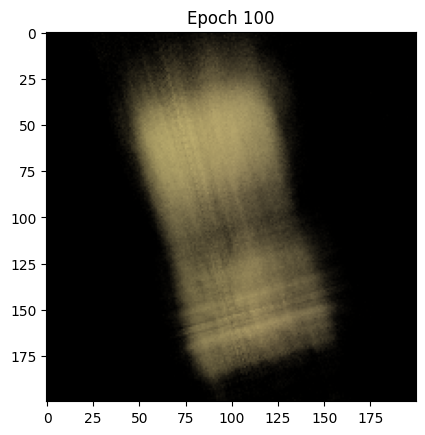

Epoch 500/5000, Loss: 0.0115, PSNR: 19.38


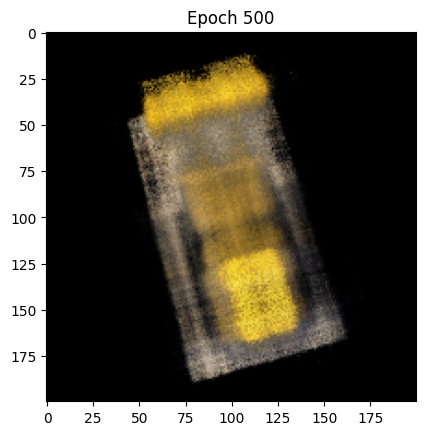

Epoch 1000/5000, Loss: 0.0069, PSNR: 21.59


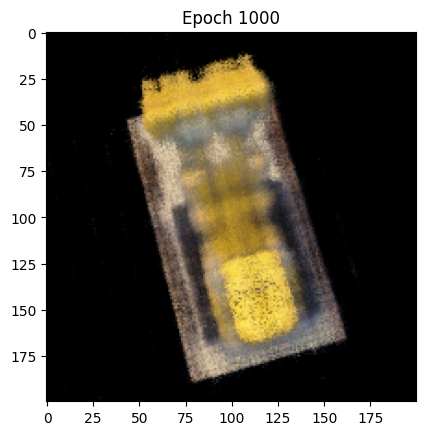

Epoch 2000/5000, Loss: 0.0049, PSNR: 23.09


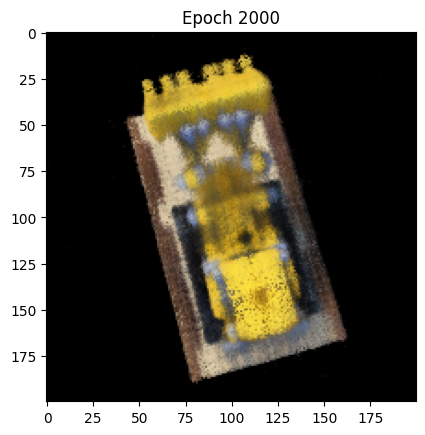

Epoch 4000/5000, Loss: 0.0045, PSNR: 23.51


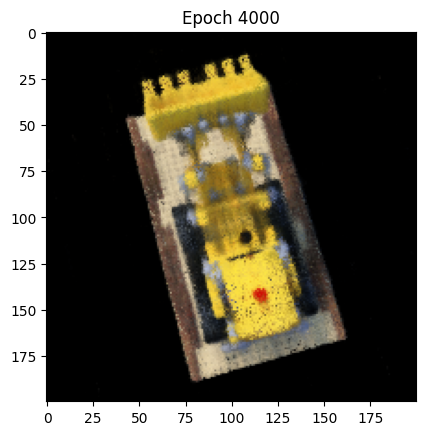

Epoch 5000/5000, Loss: 0.0036, PSNR: 24.40


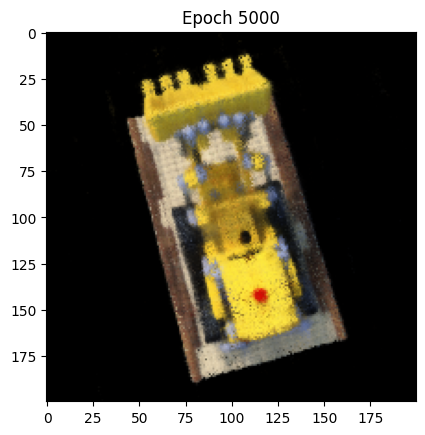

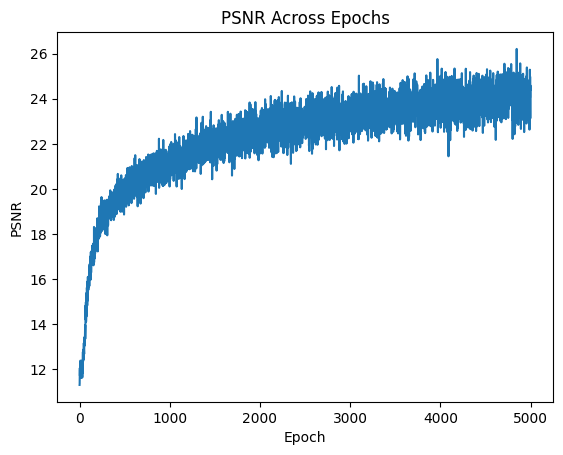

In [24]:
dataset = RaysData(images_train, K, c2ws_train)
num_epochs = 5000
batch_size = 1024
learning_rate = 5e-4
near, far, n_samples = 2.0, 6.0, 64

model = NeuralRadianceField().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

train_psnr = []

for epoch in range(1, num_epochs + 1):
    rays_o, rays_d, gt_colors = dataset.sample_rays(batch_size)
    rays_o, rays_d, gt_colors = (
        rays_o.to(device).to(torch.float32),
        rays_d.to(device).to(torch.float32),
        gt_colors.to(device).to(torch.float32)
    )

    points, t_vals = sample_along_rays(rays_o, rays_d, near, far, n_samples)
    points_flat = points.view(-1, 3).to(torch.float32)
    rays_d_flat = rays_d.unsqueeze(1).repeat(1, n_samples, 1).view(-1, 3).to(torch.float32)

    rgbs, sigmas = model(points_flat, rays_d_flat)
    rgbs = rgbs.view(batch_size, n_samples, 3)
    sigmas = sigmas.view(batch_size, n_samples, 1)

    rendered_colors = volrend(sigmas, rgbs, (far - near) / n_samples)
    loss = loss_fn(rendered_colors, gt_colors)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    psnr = -10 * torch.log10(loss).item()
    train_psnr.append(psnr)

    if epoch in [100, 500, 1000, 2000, 4000, 5000]:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, PSNR: {psnr:.2f}")

        with torch.no_grad():
            val_c2w = c2ws_val[0]
            val_rendered_colors = render_validation_image(
                dataset, model, K.to(device).to(torch.float32),
                torch.tensor(val_c2w, device=device, dtype=torch.float32),
                H, W, near, far, n_samples
            )
            plt.imshow(val_rendered_colors)
            plt.title(f"Epoch {epoch}")
            plt.show()

plt.plot(train_psnr)
plt.title("PSNR Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.show()

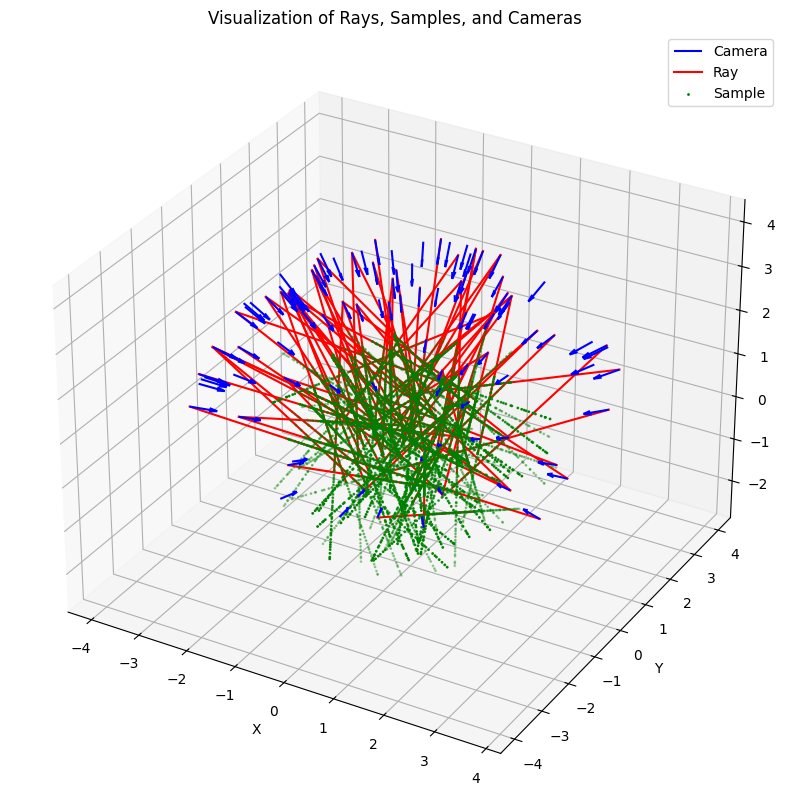

In [25]:
def visualize_rays_and_samples(dataset, c2ws_train, K, near, far, n_samples, num_rays=100):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i, c2w in enumerate(c2ws_train):
        origin = c2w[:3, 3]
        direction = c2w[:3, 2] * 0.5
        ax.quiver(origin[0], origin[1], origin[2], direction[0], direction[1], direction[2], color='blue', label='Camera' if i == 0 else None)

    rays_o, rays_d, _ = dataset.sample_rays(num_rays)
    points, _ = sample_along_rays(rays_o, rays_d, near, far, n_samples)

    rays_o = rays_o.cpu().numpy()
    rays_d = rays_d.cpu().numpy()
    points = points.cpu().numpy()

    for i in range(num_rays):
        ray_end = rays_o[i] + rays_d[i] * (far - near)
        ax.plot([rays_o[i, 0], ray_end[0]],
                [rays_o[i, 1], ray_end[1]],
                [rays_o[i, 2], ray_end[2]], color='red', label='Ray' if i == 0 else None)

        ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], color='green', s=1, label='Sample' if i == 0 else None)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Visualization of Rays, Samples, and Cameras")
    ax.legend()
    plt.show()

visualize_rays_and_samples(dataset, c2ws_train, K, near, far, n_samples, num_rays=100)

In [26]:
output_folder = "output_frames"
os.makedirs(output_folder, exist_ok=True)

rendered_frames = []
background_color = (0.5, 0.7, 1.0)

for i, c2w in enumerate(c2ws_test):
    print(f"Rendering frame {i+1}/{len(c2ws_test)}...")
    with torch.no_grad():
        if isinstance(c2w, np.ndarray):
            c2w = torch.tensor(c2w, dtype=torch.float32, device=device)
        else:
            c2w = c2w.to(device)

        rendered_image = render_validation_image(dataset, model, K.to(device), c2w, H, W, near, far, n_samples, background_color=background_color)

        frame_path = os.path.join(output_folder, f"frame_{i:03d}.png")
        plt.imsave(frame_path, np.clip(rendered_image, 0, 1))

        rendered_frames.append((rendered_image * 255).astype(np.uint8))

output_video_path = "rendered_animation.mp4"
imageio.mimwrite(output_video_path, rendered_frames, fps=24, quality=8)
print(f"Animation saved to {output_video_path}.")

def display_video(file_path):
    video_data = open(file_path, "rb").read()
    video_base64 = b64encode(video_data).decode()
    video_html = f"""
    <video controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """
    return HTML(video_html)

display_video(output_video_path)

Rendering frame 1/60...
Rendering frame 2/60...
Rendering frame 3/60...
Rendering frame 4/60...
Rendering frame 5/60...
Rendering frame 6/60...
Rendering frame 7/60...
Rendering frame 8/60...
Rendering frame 9/60...
Rendering frame 10/60...
Rendering frame 11/60...
Rendering frame 12/60...
Rendering frame 13/60...
Rendering frame 14/60...
Rendering frame 15/60...
Rendering frame 16/60...
Rendering frame 17/60...
Rendering frame 18/60...
Rendering frame 19/60...
Rendering frame 20/60...
Rendering frame 21/60...
Rendering frame 22/60...
Rendering frame 23/60...
Rendering frame 24/60...
Rendering frame 25/60...
Rendering frame 26/60...
Rendering frame 27/60...
Rendering frame 28/60...
Rendering frame 29/60...
Rendering frame 30/60...
Rendering frame 31/60...
Rendering frame 32/60...
Rendering frame 33/60...
Rendering frame 34/60...
Rendering frame 35/60...
Rendering frame 36/60...
Rendering frame 37/60...
Rendering frame 38/60...
Rendering frame 39/60...
Rendering frame 40/60...
Rendering

Animation saved to rendered_animation.mp4.
